In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torch.nn as nn

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC
from kernel.sgld import SGLD
from kernel.sgd import SGD
from kernel.sgnuts import NUTS as SGNUTS

pyro.set_rng_seed(101)

plt.rcParams['figure.dpi'] = 300

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [3]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

In [4]:
BATCH_SIZE = 500
NUM_EPOCHS = 800
WARMUP_EPOCHS = 150
HIDDEN_SIZE = 100

### Download CIFAR10 and setup datasets / dataloaders

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_dataset = datasets.CIFAR10('./data', train=True, download=True)

val_dataset = datasets.CIFAR10('./data', train=False, download=True)
    
mean = np.array([0.4912, 0.4823, 0.4468])
std = np.array([0.2470, 0.2435, 0.2616])

# scale the datasets
X_train = torch.FloatTensor(train_dataset.data / 255.0)
X_train = torch.reshape(X_train, (len(X_train), 3, 32, 32))
Y_train = torch.LongTensor(train_dataset.targets)

X_val = torch.FloatTensor(val_dataset.data / 255.0)
X_val = torch.reshape(X_val, (len(X_val), 3, 32, 32))
Y_val = torch.LongTensor(val_dataset.targets)

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Define the Convolutional Bayesian neural network  model

In [6]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class CBNN(pyro.nn.PyroModule):
    
    def __init__(self, n_channels, hidden_size, output_size, prec=1., device='cpu'):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        
        self.n_channels = n_channels
        self.device = device
        
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_channels)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_channels//2)
        
        self.fc1 = PyroLinear(8 * 8 * n_channels // 2, hidden_size)
        
        self.fc1_w_loc = torch.zeros((hidden_size, 8 * 8 * n_channels//2), device=self.device)
        self.fc1_w_scale = torch.ones((hidden_size, 8 * 8 * n_channels//2), device=self.device) * prec
        
        self.fc1_b_loc = torch.zeros((hidden_size), device=self.device)
        self.fc1_b_scale = torch.ones((hidden_size), device=self.device) * prec
        
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(self.fc1_w_loc, self.fc1_w_scale).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(self.fc1_b_loc, self.fc1_b_scale).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        
        self.fc2_w_loc = torch.zeros((output_size, hidden_size), device=self.device)
        self.fc2_w_scale = torch.ones((output_size, hidden_size), device=self.device) * prec
        
        self.fc2_b_loc = torch.zeros((output_size), device=self.device)
        self.fc2_b_scale = torch.ones((output_size), device=self.device) * prec
        
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(self.fc2_w_loc, self.fc2_w_scale).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(self.fc2_b_loc, self.fc2_b_scale).to_event(1))
        
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.to(self.device)
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = self.conv2_batchnorm(self.conv2(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = x.view(-1, 8 * 8 * self.n_channels//2)
        
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        if y is not None:
            y = y.to(self.device)
            
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Deeper model

*Experimental* doesn't seem to work well at the moment.

In [7]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class deep_CBNN(pyro.nn.PyroModule):
    
    def __init__(self, output_size, prec=1., device='cpu'):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.device = device
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv3_batchnorm = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = PyroLinear(128 * 2 * 2, 128)
        
        self.fc1_w_loc = torch.zeros((128, 128 * 2 * 2), device=self.device)
        self.fc1_w_scale = torch.ones((128, 128 * 2 * 2), device=self.device) * prec
        
        self.fc1_b_loc = torch.zeros((128), device=self.device)
        self.fc1_b_scale = torch.ones((128), device=self.device) * prec
        
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(self.fc1_w_loc, self.fc1_w_scale).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(self.fc1_b_loc, self.fc1_b_scale).to_event(1))
        
        self.fc2 = PyroLinear(128, 64)
        
        self.fc2_w_loc = torch.zeros((64, 128), device=self.device)
        self.fc2_w_scale = torch.ones((64, 128), device=self.device) * prec
        
        self.fc2_b_loc = torch.zeros((64), device=self.device)
        self.fc2_b_scale = torch.ones((64), device=self.device) * prec
        
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(self.fc2_w_loc, self.fc2_w_scale).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(self.fc2_b_loc, self.fc2_b_scale).to_event(1))
        
        self.fc3 = PyroLinear(64, 32)
        
        self.fc3_w_loc = torch.zeros((32, 64), device=self.device)
        self.fc3_w_scale = torch.ones((32, 64), device=self.device) * prec
        
        self.fc3_b_loc = torch.zeros((32), device=self.device)
        self.fc3_b_scale = torch.ones((32), device=self.device) * prec
        
        self.fc3.weight = pyro.nn.PyroSample(dist.Normal(self.fc3_w_loc, self.fc3_w_scale).to_event(2))
        self.fc3.bias   = pyro.nn.PyroSample(dist.Normal(self.fc3_b_loc, self.fc3_b_scale).to_event(1))
        
        self.fc4 = PyroLinear(32, output_size)
        
        self.fc4_w_loc = torch.zeros((output_size, 32), device=self.device)
        self.fc4_w_scale = torch.ones((output_size, 32), device=self.device) * prec
        
        self.fc4_b_loc = torch.zeros((output_size), device=self.device)
        self.fc4_b_scale = torch.ones((output_size), device=self.device) * prec
        
        self.fc4.weight = pyro.nn.PyroSample(dist.Normal(self.fc4_w_loc, self.fc4_w_scale).to_event(2))
        self.fc4.bias   = pyro.nn.PyroSample(dist.Normal(self.fc4_b_loc, self.fc4_b_scale).to_event(1))
        
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.to(self.device)
        x = self.conv1_batchnorm(self.conv1(x))
        x = self.pool(torch.tanh(x))
        x = self.conv2_batchnorm(self.conv2(x))
        x = self.pool(torch.tanh(x))
        x = self.conv3_batchnorm(self.conv3(x))
        x = self.pool(torch.tanh(x))
        x = x.view(-1, 128 * 2 * 2)
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        if y is not None:
            y = y.to(self.device)
            
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution.

In [8]:
LR = 1e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1

pyro.clear_param_store()

bnn = CBNN(32, HIDDEN_SIZE, 10, device=device).to(device)
# bnn = deep_CBNN(10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0, mp_context="spawn")

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    bnn.train()
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        bnn.eval()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
        
            epoch_predictive = epoch_predictive.cpu()
            
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.37it/s, lr=1.00e-06]


Epoch [0/800] test accuracy: 0.3867 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.19it/s, lr=1.00e-06]


Epoch [1/800] test accuracy: 0.3910 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.62it/s, lr=1.00e-06]


Epoch [2/800] test accuracy: 0.3890 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.91it/s, lr=1.00e-06]


Epoch [3/800] test accuracy: 0.3905 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.41it/s, lr=1.00e-06]


Epoch [4/800] test accuracy: 0.3910 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.10it/s, lr=1.00e-06]


Epoch [5/800] test accuracy: 0.3939 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [6/800] test accuracy: 0.3952 time: 15.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.64it/s, lr=1.00e-06]


Epoch [7/800] test accuracy: 0.3955 time: 15.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.42it/s, lr=1.00e-06]


Epoch [8/800] test accuracy: 0.3929 time: 15.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.10it/s, lr=1.00e-06]


Epoch [9/800] test accuracy: 0.3948 time: 15.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.96it/s, lr=1.00e-06]


Epoch [10/800] test accuracy: 0.3961 time: 15.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.32it/s, lr=1.00e-06]


Epoch [11/800] test accuracy: 0.3957 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.91it/s, lr=1.00e-06]


Epoch [12/800] test accuracy: 0.3963 time: 15.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [13/800] test accuracy: 0.3959 time: 15.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.39it/s, lr=1.00e-06]


Epoch [14/800] test accuracy: 0.3966 time: 15.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.28it/s, lr=1.00e-06]


Epoch [15/800] test accuracy: 0.3972 time: 15.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.71it/s, lr=1.00e-06]


Epoch [16/800] test accuracy: 0.3972 time: 15.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.78it/s, lr=1.00e-06]


Epoch [17/800] test accuracy: 0.3979 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.57it/s, lr=1.00e-06]


Epoch [18/800] test accuracy: 0.3973 time: 15.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [19/800] test accuracy: 0.3980 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.53it/s, lr=1.00e-06]


Epoch [20/800] test accuracy: 0.3982 time: 15.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.71it/s, lr=1.00e-06]


Epoch [21/800] test accuracy: 0.3983 time: 15.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.26it/s, lr=1.00e-06]


Epoch [22/800] test accuracy: 0.3978 time: 15.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [23/800] test accuracy: 0.3984 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.51it/s, lr=1.00e-06]


Epoch [24/800] test accuracy: 0.3984 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [25/800] test accuracy: 0.3978 time: 15.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.33it/s, lr=1.00e-06]


Epoch [26/800] test accuracy: 0.3971 time: 15.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.34it/s, lr=1.00e-06]


Epoch [27/800] test accuracy: 0.3966 time: 15.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.25it/s, lr=1.00e-06]


Epoch [28/800] test accuracy: 0.3966 time: 15.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.25it/s, lr=1.00e-06]


Epoch [29/800] test accuracy: 0.3966 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.12it/s, lr=1.00e-06]


Epoch [30/800] test accuracy: 0.3956 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.91it/s, lr=1.00e-06]


Epoch [31/800] test accuracy: 0.3954 time: 15.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.12it/s, lr=1.00e-06]


Epoch [32/800] test accuracy: 0.3959 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [33/800] test accuracy: 0.3964 time: 15.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [34/800] test accuracy: 0.3981 time: 15.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.53it/s, lr=1.00e-06]


Epoch [35/800] test accuracy: 0.3976 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.38it/s, lr=1.00e-06]


Epoch [36/800] test accuracy: 0.3985 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.64it/s, lr=1.00e-06]


Epoch [37/800] test accuracy: 0.3986 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.29it/s, lr=1.00e-06]


Epoch [38/800] test accuracy: 0.3979 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [39/800] test accuracy: 0.3986 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.73it/s, lr=1.00e-06]


Epoch [40/800] test accuracy: 0.3984 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.01it/s, lr=1.00e-06]


Epoch [41/800] test accuracy: 0.3979 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [42/800] test accuracy: 0.3977 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.88it/s, lr=1.00e-06]


Epoch [43/800] test accuracy: 0.3989 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.04it/s, lr=1.00e-06]


Epoch [44/800] test accuracy: 0.3986 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [45/800] test accuracy: 0.3986 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [46/800] test accuracy: 0.3989 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.31it/s, lr=1.00e-06]


Epoch [47/800] test accuracy: 0.3990 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.49it/s, lr=1.00e-06]


Epoch [48/800] test accuracy: 0.4002 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.09it/s, lr=1.00e-06]


Epoch [49/800] test accuracy: 0.4003 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [50/800] test accuracy: 0.4010 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [51/800] test accuracy: 0.4006 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.70it/s, lr=1.00e-06]


Epoch [52/800] test accuracy: 0.4008 time: 16.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.08it/s, lr=1.00e-06]


Epoch [53/800] test accuracy: 0.4001 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.79it/s, lr=1.00e-06]


Epoch [54/800] test accuracy: 0.3998 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.47it/s, lr=1.00e-06]


Epoch [55/800] test accuracy: 0.3997 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.06it/s, lr=1.00e-06]


Epoch [56/800] test accuracy: 0.3996 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.39it/s, lr=1.00e-06]


Epoch [57/800] test accuracy: 0.4005 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.74it/s, lr=1.00e-06]


Epoch [58/800] test accuracy: 0.4007 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [59/800] test accuracy: 0.4010 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.96it/s, lr=1.00e-06]


Epoch [60/800] test accuracy: 0.4000 time: 16.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.23it/s, lr=1.00e-06]


Epoch [61/800] test accuracy: 0.4002 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [62/800] test accuracy: 0.4007 time: 15.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [63/800] test accuracy: 0.4011 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.48it/s, lr=1.00e-06]


Epoch [64/800] test accuracy: 0.4013 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.47it/s, lr=1.00e-06]


Epoch [65/800] test accuracy: 0.4012 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.39it/s, lr=1.00e-06]


Epoch [66/800] test accuracy: 0.4006 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.90it/s, lr=1.00e-06]


Epoch [67/800] test accuracy: 0.4003 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [68/800] test accuracy: 0.4005 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.26it/s, lr=1.00e-06]


Epoch [69/800] test accuracy: 0.4003 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.40it/s, lr=1.00e-06]


Epoch [70/800] test accuracy: 0.4003 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [71/800] test accuracy: 0.4005 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.74it/s, lr=1.00e-06]


Epoch [72/800] test accuracy: 0.4006 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.74it/s, lr=1.00e-06]


Epoch [73/800] test accuracy: 0.4003 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [74/800] test accuracy: 0.4003 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.12it/s, lr=1.00e-06]


Epoch [75/800] test accuracy: 0.4012 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [76/800] test accuracy: 0.4009 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [77/800] test accuracy: 0.4004 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.22it/s, lr=1.00e-06]


Epoch [78/800] test accuracy: 0.4000 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.71it/s, lr=1.00e-06]


Epoch [79/800] test accuracy: 0.4002 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.68it/s, lr=1.00e-06]


Epoch [80/800] test accuracy: 0.4000 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.57it/s, lr=1.00e-06]


Epoch [81/800] test accuracy: 0.4003 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [82/800] test accuracy: 0.4001 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.99it/s, lr=1.00e-06]


Epoch [83/800] test accuracy: 0.4008 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [84/800] test accuracy: 0.4009 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.05it/s, lr=1.00e-06]


Epoch [85/800] test accuracy: 0.4002 time: 16.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.96it/s, lr=1.00e-06]


Epoch [86/800] test accuracy: 0.4001 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [87/800] test accuracy: 0.3999 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [88/800] test accuracy: 0.3998 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [89/800] test accuracy: 0.3992 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [90/800] test accuracy: 0.3994 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.95it/s, lr=1.00e-06]


Epoch [91/800] test accuracy: 0.3997 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [92/800] test accuracy: 0.3999 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.32it/s, lr=1.00e-06]


Epoch [93/800] test accuracy: 0.4001 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.25it/s, lr=1.00e-06]


Epoch [94/800] test accuracy: 0.3999 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [95/800] test accuracy: 0.3997 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [96/800] test accuracy: 0.3997 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.71it/s, lr=1.00e-06]


Epoch [97/800] test accuracy: 0.4008 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.38it/s, lr=1.00e-06]


Epoch [98/800] test accuracy: 0.4014 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [99/800] test accuracy: 0.4014 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.93it/s, lr=1.00e-06]


Epoch [100/800] test accuracy: 0.4018 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.10it/s, lr=1.00e-06]


Epoch [101/800] test accuracy: 0.4021 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.90it/s, lr=1.00e-06]


Epoch [102/800] test accuracy: 0.4018 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.56it/s, lr=1.00e-06]


Epoch [103/800] test accuracy: 0.4019 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.96it/s, lr=1.00e-06]


Epoch [104/800] test accuracy: 0.4019 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [105/800] test accuracy: 0.4021 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [106/800] test accuracy: 0.4013 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [107/800] test accuracy: 0.4016 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.71it/s, lr=1.00e-06]


Epoch [108/800] test accuracy: 0.4020 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.14it/s, lr=1.00e-06]


Epoch [109/800] test accuracy: 0.4019 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [110/800] test accuracy: 0.4025 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [111/800] test accuracy: 0.4027 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [112/800] test accuracy: 0.4028 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [113/800] test accuracy: 0.4031 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.16it/s, lr=1.00e-06]


Epoch [114/800] test accuracy: 0.4035 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.55it/s, lr=1.00e-06]


Epoch [115/800] test accuracy: 0.4039 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.39it/s, lr=1.00e-06]


Epoch [116/800] test accuracy: 0.4041 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [117/800] test accuracy: 0.4038 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.76it/s, lr=1.00e-06]


Epoch [118/800] test accuracy: 0.4036 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [119/800] test accuracy: 0.4037 time: 15.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [120/800] test accuracy: 0.4041 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.18it/s, lr=1.00e-06]


Epoch [121/800] test accuracy: 0.4038 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.33it/s, lr=1.00e-06]


Epoch [122/800] test accuracy: 0.4035 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.21it/s, lr=1.00e-06]


Epoch [123/800] test accuracy: 0.4037 time: 15.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [124/800] test accuracy: 0.4035 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [125/800] test accuracy: 0.4032 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [126/800] test accuracy: 0.4035 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.70it/s, lr=1.00e-06]


Epoch [127/800] test accuracy: 0.4037 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.66it/s, lr=1.00e-06]


Epoch [128/800] test accuracy: 0.4039 time: 15.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [129/800] test accuracy: 0.4048 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [130/800] test accuracy: 0.4046 time: 15.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [131/800] test accuracy: 0.4042 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [132/800] test accuracy: 0.4035 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.72it/s, lr=1.00e-06]


Epoch [133/800] test accuracy: 0.4033 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.67it/s, lr=1.00e-06]


Epoch [134/800] test accuracy: 0.4034 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.86it/s, lr=1.00e-06]


Epoch [135/800] test accuracy: 0.4040 time: 15.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [136/800] test accuracy: 0.4037 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.46it/s, lr=1.00e-06]


Epoch [137/800] test accuracy: 0.4036 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.88it/s, lr=1.00e-06]


Epoch [138/800] test accuracy: 0.4032 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [139/800] test accuracy: 0.4035 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.94it/s, lr=1.00e-06]


Epoch [140/800] test accuracy: 0.4033 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [141/800] test accuracy: 0.4034 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [142/800] test accuracy: 0.4031 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [143/800] test accuracy: 0.4031 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [144/800] test accuracy: 0.4030 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [145/800] test accuracy: 0.4038 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.96it/s, lr=1.00e-06]


Epoch [146/800] test accuracy: 0.4042 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.56it/s, lr=1.00e-06]


Epoch [147/800] test accuracy: 0.4043 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [148/800] test accuracy: 0.4042 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [149/800] test accuracy: 0.4044 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [150/800] test accuracy: 0.4044 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.91it/s, lr=1.00e-06]


Epoch [151/800] test accuracy: 0.4041 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.87it/s, lr=1.00e-06]


Epoch [152/800] test accuracy: 0.4042 time: 15.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [153/800] test accuracy: 0.4041 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [154/800] test accuracy: 0.4041 time: 15.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.84it/s, lr=1.00e-06]


Epoch [155/800] test accuracy: 0.4040 time: 15.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.40it/s, lr=1.00e-06]


Epoch [156/800] test accuracy: 0.4041 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [157/800] test accuracy: 0.4042 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.59it/s, lr=1.00e-06]


Epoch [158/800] test accuracy: 0.4042 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [159/800] test accuracy: 0.4048 time: 15.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [160/800] test accuracy: 0.4045 time: 15.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.15it/s, lr=1.00e-06]


Epoch [161/800] test accuracy: 0.4046 time: 15.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.61it/s, lr=1.00e-06]


Epoch [162/800] test accuracy: 0.4048 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [163/800] test accuracy: 0.4046 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.93it/s, lr=1.00e-06]


Epoch [164/800] test accuracy: 0.4044 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [165/800] test accuracy: 0.4041 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [166/800] test accuracy: 0.4036 time: 15.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.93it/s, lr=1.00e-06]


Epoch [167/800] test accuracy: 0.4039 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.68it/s, lr=1.00e-06]


Epoch [168/800] test accuracy: 0.4042 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [169/800] test accuracy: 0.4042 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.21it/s, lr=1.00e-06]


Epoch [170/800] test accuracy: 0.4044 time: 16.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.06it/s, lr=1.00e-06]


Epoch [171/800] test accuracy: 0.4045 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [172/800] test accuracy: 0.4049 time: 15.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.71it/s, lr=1.00e-06]


Epoch [173/800] test accuracy: 0.4047 time: 15.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.60it/s, lr=1.00e-06]


Epoch [174/800] test accuracy: 0.4049 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [175/800] test accuracy: 0.4048 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.65it/s, lr=1.00e-06]


Epoch [176/800] test accuracy: 0.4045 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [177/800] test accuracy: 0.4044 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [178/800] test accuracy: 0.4046 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.18it/s, lr=1.00e-06]


Epoch [179/800] test accuracy: 0.4044 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [180/800] test accuracy: 0.4048 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [181/800] test accuracy: 0.4054 time: 15.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.84it/s, lr=1.00e-06]


Epoch [182/800] test accuracy: 0.4060 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.79it/s, lr=1.00e-06]


Epoch [183/800] test accuracy: 0.4054 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [184/800] test accuracy: 0.4061 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [185/800] test accuracy: 0.4065 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [186/800] test accuracy: 0.4064 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [187/800] test accuracy: 0.4070 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.51it/s, lr=1.00e-06]


Epoch [188/800] test accuracy: 0.4074 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.10it/s, lr=1.00e-06]


Epoch [189/800] test accuracy: 0.4074 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [190/800] test accuracy: 0.4070 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.43it/s, lr=1.00e-06]


Epoch [191/800] test accuracy: 0.4071 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [192/800] test accuracy: 0.4071 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.34it/s, lr=1.00e-06]


Epoch [193/800] test accuracy: 0.4074 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [194/800] test accuracy: 0.4077 time: 16.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.55it/s, lr=1.00e-06]


Epoch [195/800] test accuracy: 0.4075 time: 16.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [196/800] test accuracy: 0.4077 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [197/800] test accuracy: 0.4079 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [198/800] test accuracy: 0.4079 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [199/800] test accuracy: 0.4079 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [200/800] test accuracy: 0.4077 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.44it/s, lr=1.00e-06]


Epoch [201/800] test accuracy: 0.4073 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [202/800] test accuracy: 0.4072 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [203/800] test accuracy: 0.4072 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.96it/s, lr=1.00e-06]


Epoch [204/800] test accuracy: 0.4068 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.91it/s, lr=1.00e-06]


Epoch [205/800] test accuracy: 0.4072 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.83it/s, lr=1.00e-06]


Epoch [206/800] test accuracy: 0.4073 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.17it/s, lr=1.00e-06]


Epoch [207/800] test accuracy: 0.4075 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [208/800] test accuracy: 0.4073 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [209/800] test accuracy: 0.4071 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.45it/s, lr=1.00e-06]


Epoch [210/800] test accuracy: 0.4073 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.52it/s, lr=1.00e-06]


Epoch [211/800] test accuracy: 0.4075 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [212/800] test accuracy: 0.4075 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.06it/s, lr=1.00e-06]


Epoch [213/800] test accuracy: 0.4073 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.23it/s, lr=1.00e-06]


Epoch [214/800] test accuracy: 0.4073 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [215/800] test accuracy: 0.4070 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [216/800] test accuracy: 0.4072 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.12it/s, lr=1.00e-06]


Epoch [217/800] test accuracy: 0.4078 time: 15.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [218/800] test accuracy: 0.4080 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.06it/s, lr=1.00e-06]


Epoch [219/800] test accuracy: 0.4083 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [220/800] test accuracy: 0.4081 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.46it/s, lr=1.00e-06]


Epoch [221/800] test accuracy: 0.4077 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.44it/s, lr=1.00e-06]


Epoch [222/800] test accuracy: 0.4079 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.56it/s, lr=1.00e-06]


Epoch [223/800] test accuracy: 0.4080 time: 15.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [224/800] test accuracy: 0.4081 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.87it/s, lr=1.00e-06]


Epoch [225/800] test accuracy: 0.4082 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.20it/s, lr=1.00e-06]


Epoch [226/800] test accuracy: 0.4078 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [227/800] test accuracy: 0.4078 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [228/800] test accuracy: 0.4075 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [229/800] test accuracy: 0.4074 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.57it/s, lr=1.00e-06]


Epoch [230/800] test accuracy: 0.4074 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.84it/s, lr=1.00e-06]


Epoch [231/800] test accuracy: 0.4081 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [232/800] test accuracy: 0.4077 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [233/800] test accuracy: 0.4075 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [234/800] test accuracy: 0.4078 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [235/800] test accuracy: 0.4075 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [236/800] test accuracy: 0.4075 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.09it/s, lr=1.00e-06]


Epoch [237/800] test accuracy: 0.4076 time: 16.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.14it/s, lr=1.00e-06]


Epoch [238/800] test accuracy: 0.4073 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.27it/s, lr=1.00e-06]


Epoch [239/800] test accuracy: 0.4071 time: 15.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [240/800] test accuracy: 0.4073 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [241/800] test accuracy: 0.4073 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.57it/s, lr=1.00e-06]


Epoch [242/800] test accuracy: 0.4074 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.22it/s, lr=1.00e-06]


Epoch [243/800] test accuracy: 0.4074 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.66it/s, lr=1.00e-06]


Epoch [244/800] test accuracy: 0.4074 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.91it/s, lr=1.00e-06]


Epoch [245/800] test accuracy: 0.4075 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [246/800] test accuracy: 0.4078 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [247/800] test accuracy: 0.4080 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [248/800] test accuracy: 0.4080 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.38it/s, lr=1.00e-06]


Epoch [249/800] test accuracy: 0.4080 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.89it/s, lr=1.00e-06]


Epoch [250/800] test accuracy: 0.4083 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.83it/s, lr=1.00e-06]


Epoch [251/800] test accuracy: 0.4082 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.46it/s, lr=1.00e-06]


Epoch [252/800] test accuracy: 0.4081 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [253/800] test accuracy: 0.4084 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.68it/s, lr=1.00e-06]


Epoch [254/800] test accuracy: 0.4085 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [255/800] test accuracy: 0.4081 time: 16.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.94it/s, lr=1.00e-06]


Epoch [256/800] test accuracy: 0.4082 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [257/800] test accuracy: 0.4089 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [258/800] test accuracy: 0.4090 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.48it/s, lr=1.00e-06]


Epoch [259/800] test accuracy: 0.4088 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [260/800] test accuracy: 0.4091 time: 15.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.59it/s, lr=1.00e-06]


Epoch [261/800] test accuracy: 0.4091 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 23.67it/s, lr=1.00e-06]


Epoch [262/800] test accuracy: 0.4089 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [263/800] test accuracy: 0.4092 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [264/800] test accuracy: 0.4094 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [265/800] test accuracy: 0.4091 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [266/800] test accuracy: 0.4095 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [267/800] test accuracy: 0.4095 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [268/800] test accuracy: 0.4096 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [269/800] test accuracy: 0.4096 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [270/800] test accuracy: 0.4098 time: 15.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.34it/s, lr=1.00e-06]


Epoch [271/800] test accuracy: 0.4099 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [272/800] test accuracy: 0.4096 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [273/800] test accuracy: 0.4097 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.30it/s, lr=1.00e-06]


Epoch [274/800] test accuracy: 0.4098 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [275/800] test accuracy: 0.4102 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [276/800] test accuracy: 0.4106 time: 15.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [277/800] test accuracy: 0.4105 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.34it/s, lr=1.00e-06]


Epoch [278/800] test accuracy: 0.4105 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [279/800] test accuracy: 0.4102 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.90it/s, lr=1.00e-06]


Epoch [280/800] test accuracy: 0.4101 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.41it/s, lr=1.00e-06]


Epoch [281/800] test accuracy: 0.4098 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [282/800] test accuracy: 0.4101 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [283/800] test accuracy: 0.4103 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.45it/s, lr=1.00e-06]


Epoch [284/800] test accuracy: 0.4101 time: 15.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [285/800] test accuracy: 0.4099 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.10it/s, lr=1.00e-06]


Epoch [286/800] test accuracy: 0.4099 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [287/800] test accuracy: 0.4106 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.04it/s, lr=1.00e-06]


Epoch [288/800] test accuracy: 0.4102 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.52it/s, lr=1.00e-06]


Epoch [289/800] test accuracy: 0.4105 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.52it/s, lr=1.00e-06]


Epoch [290/800] test accuracy: 0.4107 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.31it/s, lr=1.00e-06]


Epoch [291/800] test accuracy: 0.4107 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.68it/s, lr=1.00e-06]


Epoch [292/800] test accuracy: 0.4106 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.45it/s, lr=1.00e-06]


Epoch [293/800] test accuracy: 0.4110 time: 15.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [294/800] test accuracy: 0.4108 time: 15.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [295/800] test accuracy: 0.4110 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [296/800] test accuracy: 0.4106 time: 16.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [297/800] test accuracy: 0.4108 time: 15.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.99it/s, lr=1.00e-06]


Epoch [298/800] test accuracy: 0.4110 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.50it/s, lr=1.00e-06]


Epoch [299/800] test accuracy: 0.4109 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [300/800] test accuracy: 0.4109 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [301/800] test accuracy: 0.4110 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [302/800] test accuracy: 0.4110 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.38it/s, lr=1.00e-06]


Epoch [303/800] test accuracy: 0.4110 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.86it/s, lr=1.00e-06]


Epoch [304/800] test accuracy: 0.4107 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.05it/s, lr=1.00e-06]


Epoch [305/800] test accuracy: 0.4108 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [306/800] test accuracy: 0.4107 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [307/800] test accuracy: 0.4106 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [308/800] test accuracy: 0.4105 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [309/800] test accuracy: 0.4106 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.86it/s, lr=1.00e-06]


Epoch [310/800] test accuracy: 0.4105 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.46it/s, lr=1.00e-06]


Epoch [311/800] test accuracy: 0.4106 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.47it/s, lr=1.00e-06]


Epoch [312/800] test accuracy: 0.4107 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [313/800] test accuracy: 0.4108 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.43it/s, lr=1.00e-06]


Epoch [314/800] test accuracy: 0.4110 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [315/800] test accuracy: 0.4105 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.06it/s, lr=1.00e-06]


Epoch [316/800] test accuracy: 0.4105 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.97it/s, lr=1.00e-06]


Epoch [317/800] test accuracy: 0.4106 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [318/800] test accuracy: 0.4107 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [319/800] test accuracy: 0.4107 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [320/800] test accuracy: 0.4109 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.61it/s, lr=1.00e-06]


Epoch [321/800] test accuracy: 0.4109 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [322/800] test accuracy: 0.4110 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.60it/s, lr=1.00e-06]


Epoch [323/800] test accuracy: 0.4109 time: 16.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [324/800] test accuracy: 0.4107 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.57it/s, lr=1.00e-06]


Epoch [325/800] test accuracy: 0.4104 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [326/800] test accuracy: 0.4103 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [327/800] test accuracy: 0.4099 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [328/800] test accuracy: 0.4097 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.12it/s, lr=1.00e-06]


Epoch [329/800] test accuracy: 0.4101 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [330/800] test accuracy: 0.4102 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [331/800] test accuracy: 0.4106 time: 15.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [332/800] test accuracy: 0.4104 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.27it/s, lr=1.00e-06]


Epoch [333/800] test accuracy: 0.4099 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.57it/s, lr=1.00e-06]


Epoch [334/800] test accuracy: 0.4106 time: 16.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [335/800] test accuracy: 0.4105 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.22it/s, lr=1.00e-06]


Epoch [336/800] test accuracy: 0.4106 time: 15.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [337/800] test accuracy: 0.4105 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [338/800] test accuracy: 0.4104 time: 15.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [339/800] test accuracy: 0.4101 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [340/800] test accuracy: 0.4099 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.71it/s, lr=1.00e-06]


Epoch [341/800] test accuracy: 0.4100 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [342/800] test accuracy: 0.4102 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.81it/s, lr=1.00e-06]


Epoch [343/800] test accuracy: 0.4101 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.28it/s, lr=1.00e-06]


Epoch [344/800] test accuracy: 0.4100 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.26it/s, lr=1.00e-06]


Epoch [345/800] test accuracy: 0.4100 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [346/800] test accuracy: 0.4101 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.03it/s, lr=1.00e-06]


Epoch [347/800] test accuracy: 0.4100 time: 16.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.64it/s, lr=1.00e-06]


Epoch [348/800] test accuracy: 0.4099 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [349/800] test accuracy: 0.4100 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [350/800] test accuracy: 0.4103 time: 15.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [351/800] test accuracy: 0.4105 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [352/800] test accuracy: 0.4100 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.07it/s, lr=1.00e-06]


Epoch [353/800] test accuracy: 0.4099 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [354/800] test accuracy: 0.4102 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.43it/s, lr=1.00e-06]


Epoch [355/800] test accuracy: 0.4101 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.29it/s, lr=1.00e-06]


Epoch [356/800] test accuracy: 0.4099 time: 15.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.22it/s, lr=1.00e-06]


Epoch [357/800] test accuracy: 0.4095 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [358/800] test accuracy: 0.4091 time: 16.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.49it/s, lr=1.00e-06]


Epoch [359/800] test accuracy: 0.4095 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.27it/s, lr=1.00e-06]


Epoch [360/800] test accuracy: 0.4100 time: 15.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [361/800] test accuracy: 0.4103 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [362/800] test accuracy: 0.4101 time: 15.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.73it/s, lr=1.00e-06]


Epoch [363/800] test accuracy: 0.4102 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [364/800] test accuracy: 0.4106 time: 15.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.92it/s, lr=1.00e-06]


Epoch [365/800] test accuracy: 0.4105 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.64it/s, lr=1.00e-06]


Epoch [366/800] test accuracy: 0.4107 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [367/800] test accuracy: 0.4107 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [368/800] test accuracy: 0.4107 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [369/800] test accuracy: 0.4106 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [370/800] test accuracy: 0.4111 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [371/800] test accuracy: 0.4107 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [372/800] test accuracy: 0.4104 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [373/800] test accuracy: 0.4107 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [374/800] test accuracy: 0.4101 time: 15.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [375/800] test accuracy: 0.4104 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [376/800] test accuracy: 0.4105 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.68it/s, lr=1.00e-06]


Epoch [377/800] test accuracy: 0.4106 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.65it/s, lr=1.00e-06]


Epoch [378/800] test accuracy: 0.4112 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [379/800] test accuracy: 0.4113 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.38it/s, lr=1.00e-06]


Epoch [380/800] test accuracy: 0.4112 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [381/800] test accuracy: 0.4111 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [382/800] test accuracy: 0.4111 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.05it/s, lr=1.00e-06]


Epoch [383/800] test accuracy: 0.4112 time: 16.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.90it/s, lr=1.00e-06]


Epoch [384/800] test accuracy: 0.4112 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.68it/s, lr=1.00e-06]


Epoch [385/800] test accuracy: 0.4111 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [386/800] test accuracy: 0.4112 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.78it/s, lr=1.00e-06]


Epoch [387/800] test accuracy: 0.4115 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [388/800] test accuracy: 0.4116 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.10it/s, lr=1.00e-06]


Epoch [389/800] test accuracy: 0.4112 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [390/800] test accuracy: 0.4116 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [391/800] test accuracy: 0.4115 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.60it/s, lr=1.00e-06]


Epoch [392/800] test accuracy: 0.4116 time: 15.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [393/800] test accuracy: 0.4113 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.02it/s, lr=1.00e-06]


Epoch [394/800] test accuracy: 0.4117 time: 15.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.41it/s, lr=1.00e-06]


Epoch [395/800] test accuracy: 0.4117 time: 16.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [396/800] test accuracy: 0.4113 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.78it/s, lr=1.00e-06]


Epoch [397/800] test accuracy: 0.4114 time: 15.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.60it/s, lr=1.00e-06]


Epoch [398/800] test accuracy: 0.4112 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [399/800] test accuracy: 0.4115 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.04it/s, lr=1.00e-06]


Epoch [400/800] test accuracy: 0.4116 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.31it/s, lr=1.00e-06]


Epoch [401/800] test accuracy: 0.4111 time: 16.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.54it/s, lr=1.00e-06]


Epoch [402/800] test accuracy: 0.4113 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [403/800] test accuracy: 0.4108 time: 15.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.78it/s, lr=1.00e-06]


Epoch [404/800] test accuracy: 0.4113 time: 15.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.27it/s, lr=1.00e-06]


Epoch [405/800] test accuracy: 0.4111 time: 15.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [406/800] test accuracy: 0.4113 time: 15.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [407/800] test accuracy: 0.4111 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.43it/s, lr=1.00e-06]


Epoch [408/800] test accuracy: 0.4108 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [409/800] test accuracy: 0.4106 time: 15.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [410/800] test accuracy: 0.4108 time: 15.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.45it/s, lr=1.00e-06]


Epoch [411/800] test accuracy: 0.4111 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.45it/s, lr=1.00e-06]


Epoch [412/800] test accuracy: 0.4111 time: 15.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.83it/s, lr=1.00e-06]


Epoch [413/800] test accuracy: 0.4110 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.95it/s, lr=1.00e-06]


Epoch [414/800] test accuracy: 0.4109 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [415/800] test accuracy: 0.4107 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [416/800] test accuracy: 0.4105 time: 15.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [417/800] test accuracy: 0.4104 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [418/800] test accuracy: 0.4100 time: 15.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [419/800] test accuracy: 0.4102 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.77it/s, lr=1.00e-06]


Epoch [420/800] test accuracy: 0.4099 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [421/800] test accuracy: 0.4100 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.40it/s, lr=1.00e-06]


Epoch [422/800] test accuracy: 0.4104 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.61it/s, lr=1.00e-06]


Epoch [423/800] test accuracy: 0.4105 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.71it/s, lr=1.00e-06]


Epoch [424/800] test accuracy: 0.4107 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.64it/s, lr=1.00e-06]


Epoch [425/800] test accuracy: 0.4107 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.98it/s, lr=1.00e-06]


Epoch [426/800] test accuracy: 0.4108 time: 17.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.11it/s, lr=1.00e-06]


Epoch [427/800] test accuracy: 0.4104 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.46it/s, lr=1.00e-06]


Epoch [428/800] test accuracy: 0.4102 time: 16.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [429/800] test accuracy: 0.4102 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [430/800] test accuracy: 0.4102 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [431/800] test accuracy: 0.4103 time: 16.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.65it/s, lr=1.00e-06]


Epoch [432/800] test accuracy: 0.4106 time: 16.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.84it/s, lr=1.00e-06]


Epoch [433/800] test accuracy: 0.4105 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.88it/s, lr=1.00e-06]


Epoch [434/800] test accuracy: 0.4105 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [435/800] test accuracy: 0.4106 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [436/800] test accuracy: 0.4110 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [437/800] test accuracy: 0.4111 time: 16.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.60it/s, lr=1.00e-06]


Epoch [438/800] test accuracy: 0.4110 time: 16.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.35it/s, lr=1.00e-06]


Epoch [439/800] test accuracy: 0.4109 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [440/800] test accuracy: 0.4106 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [441/800] test accuracy: 0.4103 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.73it/s, lr=1.00e-06]


Epoch [442/800] test accuracy: 0.4104 time: 16.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.31it/s, lr=1.00e-06]


Epoch [443/800] test accuracy: 0.4104 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.65it/s, lr=1.00e-06]


Epoch [444/800] test accuracy: 0.4108 time: 16.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.60it/s, lr=1.00e-06]


Epoch [445/800] test accuracy: 0.4112 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.50it/s, lr=1.00e-06]


Epoch [446/800] test accuracy: 0.4112 time: 16.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.34it/s, lr=1.00e-06]


Epoch [447/800] test accuracy: 0.4113 time: 16.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [448/800] test accuracy: 0.4111 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [449/800] test accuracy: 0.4110 time: 16.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.62it/s, lr=1.00e-06]


Epoch [450/800] test accuracy: 0.4113 time: 16.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.43it/s, lr=1.00e-06]


Epoch [451/800] test accuracy: 0.4116 time: 16.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.28it/s, lr=1.00e-06]


Epoch [452/800] test accuracy: 0.4117 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.64it/s, lr=1.00e-06]


Epoch [453/800] test accuracy: 0.4115 time: 16.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.48it/s, lr=1.00e-06]


Epoch [454/800] test accuracy: 0.4109 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [455/800] test accuracy: 0.4111 time: 16.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.54it/s, lr=1.00e-06]


Epoch [456/800] test accuracy: 0.4113 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [457/800] test accuracy: 0.4116 time: 16.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.43it/s, lr=1.00e-06]


Epoch [458/800] test accuracy: 0.4118 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [459/800] test accuracy: 0.4120 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [460/800] test accuracy: 0.4121 time: 16.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [461/800] test accuracy: 0.4124 time: 16.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.94it/s, lr=1.00e-06]


Epoch [462/800] test accuracy: 0.4124 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [463/800] test accuracy: 0.4128 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.94it/s, lr=1.00e-06]


Epoch [464/800] test accuracy: 0.4128 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [465/800] test accuracy: 0.4129 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [466/800] test accuracy: 0.4130 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [467/800] test accuracy: 0.4129 time: 16.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.97it/s, lr=1.00e-06]


Epoch [468/800] test accuracy: 0.4128 time: 16.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [469/800] test accuracy: 0.4130 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [470/800] test accuracy: 0.4132 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [471/800] test accuracy: 0.4133 time: 16.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [472/800] test accuracy: 0.4133 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.34it/s, lr=1.00e-06]


Epoch [473/800] test accuracy: 0.4135 time: 16.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.88it/s, lr=1.00e-06]


Epoch [474/800] test accuracy: 0.4135 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [475/800] test accuracy: 0.4132 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [476/800] test accuracy: 0.4136 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [477/800] test accuracy: 0.4136 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.08it/s, lr=1.00e-06]


Epoch [478/800] test accuracy: 0.4138 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.16it/s, lr=1.00e-06]


Epoch [479/800] test accuracy: 0.4139 time: 16.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.58it/s, lr=1.00e-06]


Epoch [480/800] test accuracy: 0.4139 time: 16.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.41it/s, lr=1.00e-06]


Epoch [481/800] test accuracy: 0.4135 time: 16.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [482/800] test accuracy: 0.4135 time: 16.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.06it/s, lr=1.00e-06]


Epoch [483/800] test accuracy: 0.4142 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [484/800] test accuracy: 0.4143 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.92it/s, lr=1.00e-06]


Epoch [485/800] test accuracy: 0.4144 time: 16.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.23it/s, lr=1.00e-06]


Epoch [486/800] test accuracy: 0.4143 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.60it/s, lr=1.00e-06]


Epoch [487/800] test accuracy: 0.4145 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.20it/s, lr=1.00e-06]


Epoch [488/800] test accuracy: 0.4148 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.61it/s, lr=1.00e-06]


Epoch [489/800] test accuracy: 0.4152 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [490/800] test accuracy: 0.4153 time: 16.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.70it/s, lr=1.00e-06]


Epoch [491/800] test accuracy: 0.4152 time: 17.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.68it/s, lr=1.00e-06]


Epoch [492/800] test accuracy: 0.4156 time: 16.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.24it/s, lr=1.00e-06]


Epoch [493/800] test accuracy: 0.4156 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [494/800] test accuracy: 0.4157 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.68it/s, lr=1.00e-06]


Epoch [495/800] test accuracy: 0.4157 time: 16.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.26it/s, lr=1.00e-06]


Epoch [496/800] test accuracy: 0.4158 time: 16.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.47it/s, lr=1.00e-06]


Epoch [497/800] test accuracy: 0.4164 time: 17.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.71it/s, lr=1.00e-06]


Epoch [498/800] test accuracy: 0.4159 time: 16.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [499/800] test accuracy: 0.4156 time: 16.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [500/800] test accuracy: 0.4157 time: 16.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.44it/s, lr=1.00e-06]


Epoch [501/800] test accuracy: 0.4157 time: 16.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [502/800] test accuracy: 0.4157 time: 16.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.97it/s, lr=1.00e-06]


Epoch [503/800] test accuracy: 0.4159 time: 16.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [504/800] test accuracy: 0.4159 time: 16.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [505/800] test accuracy: 0.4159 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.55it/s, lr=1.00e-06]


Epoch [506/800] test accuracy: 0.4158 time: 16.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [507/800] test accuracy: 0.4160 time: 16.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [508/800] test accuracy: 0.4160 time: 16.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.82it/s, lr=1.00e-06]


Epoch [509/800] test accuracy: 0.4161 time: 16.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [510/800] test accuracy: 0.4162 time: 16.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [511/800] test accuracy: 0.4162 time: 16.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [512/800] test accuracy: 0.4159 time: 17.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.22it/s, lr=1.00e-06]


Epoch [513/800] test accuracy: 0.4162 time: 16.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [514/800] test accuracy: 0.4167 time: 17.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.44it/s, lr=1.00e-06]


Epoch [515/800] test accuracy: 0.4166 time: 17.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.32it/s, lr=1.00e-06]


Epoch [516/800] test accuracy: 0.4169 time: 16.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.37it/s, lr=1.00e-06]


Epoch [517/800] test accuracy: 0.4166 time: 16.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.29it/s, lr=1.00e-06]


Epoch [518/800] test accuracy: 0.4167 time: 16.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.12it/s, lr=1.00e-06]


Epoch [519/800] test accuracy: 0.4169 time: 16.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 23.94it/s, lr=1.00e-06]


Epoch [520/800] test accuracy: 0.4168 time: 17.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.60it/s, lr=1.00e-06]


Epoch [521/800] test accuracy: 0.4165 time: 16.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [522/800] test accuracy: 0.4164 time: 17.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 22.80it/s, lr=1.00e-06]


Epoch [523/800] test accuracy: 0.4164 time: 17.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 22.46it/s, lr=1.00e-06]


Epoch [524/800] test accuracy: 0.4162 time: 17.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.94it/s, lr=1.00e-06]


Epoch [525/800] test accuracy: 0.4164 time: 17.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.62it/s, lr=1.00e-06]


Epoch [526/800] test accuracy: 0.4163 time: 17.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [527/800] test accuracy: 0.4168 time: 16.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [528/800] test accuracy: 0.4170 time: 16.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.81it/s, lr=1.00e-06]


Epoch [529/800] test accuracy: 0.4173 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [530/800] test accuracy: 0.4173 time: 17.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.02it/s, lr=1.00e-06]


Epoch [531/800] test accuracy: 0.4172 time: 17.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.59it/s, lr=1.00e-06]


Epoch [532/800] test accuracy: 0.4172 time: 16.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [533/800] test accuracy: 0.4169 time: 16.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [534/800] test accuracy: 0.4169 time: 16.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.10it/s, lr=1.00e-06]


Epoch [535/800] test accuracy: 0.4168 time: 16.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [536/800] test accuracy: 0.4166 time: 17.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [537/800] test accuracy: 0.4166 time: 16.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.82it/s, lr=1.00e-06]


Epoch [538/800] test accuracy: 0.4164 time: 17.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.04it/s, lr=1.00e-06]


Epoch [539/800] test accuracy: 0.4164 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.48it/s, lr=1.00e-06]


Epoch [540/800] test accuracy: 0.4167 time: 17.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.36it/s, lr=1.00e-06]


Epoch [541/800] test accuracy: 0.4168 time: 16.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [542/800] test accuracy: 0.4167 time: 16.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.54it/s, lr=1.00e-06]


Epoch [543/800] test accuracy: 0.4170 time: 17.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.66it/s, lr=1.00e-06]


Epoch [544/800] test accuracy: 0.4171 time: 16.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.65it/s, lr=1.00e-06]


Epoch [545/800] test accuracy: 0.4171 time: 16.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.49it/s, lr=1.00e-06]


Epoch [546/800] test accuracy: 0.4172 time: 16.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [547/800] test accuracy: 0.4172 time: 16.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.59it/s, lr=1.00e-06]


Epoch [548/800] test accuracy: 0.4171 time: 16.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.81it/s, lr=1.00e-06]


Epoch [549/800] test accuracy: 0.4173 time: 16.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.58it/s, lr=1.00e-06]


Epoch [550/800] test accuracy: 0.4170 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.95it/s, lr=1.00e-06]


Epoch [551/800] test accuracy: 0.4171 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [552/800] test accuracy: 0.4174 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [553/800] test accuracy: 0.4177 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [554/800] test accuracy: 0.4177 time: 16.44


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.68it/s, lr=1.00e-06]


Epoch [555/800] test accuracy: 0.4175 time: 16.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.25it/s, lr=1.00e-06]


Epoch [556/800] test accuracy: 0.4175 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [557/800] test accuracy: 0.4175 time: 16.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.80it/s, lr=1.00e-06]


Epoch [558/800] test accuracy: 0.4175 time: 16.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.83it/s, lr=1.00e-06]


Epoch [559/800] test accuracy: 0.4175 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [560/800] test accuracy: 0.4174 time: 16.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [561/800] test accuracy: 0.4175 time: 16.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.47it/s, lr=1.00e-06]


Epoch [562/800] test accuracy: 0.4173 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.79it/s, lr=1.00e-06]


Epoch [563/800] test accuracy: 0.4173 time: 16.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [564/800] test accuracy: 0.4172 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.39it/s, lr=1.00e-06]


Epoch [565/800] test accuracy: 0.4174 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [566/800] test accuracy: 0.4173 time: 16.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.58it/s, lr=1.00e-06]


Epoch [567/800] test accuracy: 0.4173 time: 16.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.71it/s, lr=1.00e-06]


Epoch [568/800] test accuracy: 0.4175 time: 16.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [569/800] test accuracy: 0.4175 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [570/800] test accuracy: 0.4174 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [571/800] test accuracy: 0.4175 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [572/800] test accuracy: 0.4178 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.64it/s, lr=1.00e-06]


Epoch [573/800] test accuracy: 0.4178 time: 16.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [574/800] test accuracy: 0.4176 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.22it/s, lr=1.00e-06]


Epoch [575/800] test accuracy: 0.4175 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [576/800] test accuracy: 0.4175 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.93it/s, lr=1.00e-06]


Epoch [577/800] test accuracy: 0.4173 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.28it/s, lr=1.00e-06]


Epoch [578/800] test accuracy: 0.4174 time: 16.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.30it/s, lr=1.00e-06]


Epoch [579/800] test accuracy: 0.4172 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [580/800] test accuracy: 0.4171 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [581/800] test accuracy: 0.4172 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [582/800] test accuracy: 0.4173 time: 16.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [583/800] test accuracy: 0.4172 time: 16.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.53it/s, lr=1.00e-06]


Epoch [584/800] test accuracy: 0.4176 time: 16.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.60it/s, lr=1.00e-06]


Epoch [585/800] test accuracy: 0.4181 time: 16.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [586/800] test accuracy: 0.4181 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [587/800] test accuracy: 0.4181 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [588/800] test accuracy: 0.4181 time: 16.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.12it/s, lr=1.00e-06]


Epoch [589/800] test accuracy: 0.4181 time: 16.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [590/800] test accuracy: 0.4180 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.72it/s, lr=1.00e-06]


Epoch [591/800] test accuracy: 0.4181 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.62it/s, lr=1.00e-06]


Epoch [592/800] test accuracy: 0.4180 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.59it/s, lr=1.00e-06]


Epoch [593/800] test accuracy: 0.4179 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [594/800] test accuracy: 0.4178 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [595/800] test accuracy: 0.4180 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [596/800] test accuracy: 0.4180 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.10it/s, lr=1.00e-06]


Epoch [597/800] test accuracy: 0.4180 time: 16.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.10it/s, lr=1.00e-06]


Epoch [598/800] test accuracy: 0.4177 time: 15.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [599/800] test accuracy: 0.4175 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.28it/s, lr=1.00e-06]


Epoch [600/800] test accuracy: 0.4175 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.84it/s, lr=1.00e-06]


Epoch [601/800] test accuracy: 0.4174 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [602/800] test accuracy: 0.4173 time: 16.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.09it/s, lr=1.00e-06]


Epoch [603/800] test accuracy: 0.4177 time: 16.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.92it/s, lr=1.00e-06]


Epoch [604/800] test accuracy: 0.4176 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [605/800] test accuracy: 0.4178 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.92it/s, lr=1.00e-06]


Epoch [606/800] test accuracy: 0.4181 time: 17.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [607/800] test accuracy: 0.4179 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [608/800] test accuracy: 0.4178 time: 16.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.27it/s, lr=1.00e-06]


Epoch [609/800] test accuracy: 0.4178 time: 16.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.14it/s, lr=1.00e-06]


Epoch [610/800] test accuracy: 0.4176 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.79it/s, lr=1.00e-06]


Epoch [611/800] test accuracy: 0.4176 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [612/800] test accuracy: 0.4176 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [613/800] test accuracy: 0.4178 time: 16.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [614/800] test accuracy: 0.4177 time: 16.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.19it/s, lr=1.00e-06]


Epoch [615/800] test accuracy: 0.4176 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [616/800] test accuracy: 0.4178 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [617/800] test accuracy: 0.4174 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.56it/s, lr=1.00e-06]


Epoch [618/800] test accuracy: 0.4173 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.99it/s, lr=1.00e-06]


Epoch [619/800] test accuracy: 0.4174 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.67it/s, lr=1.00e-06]


Epoch [620/800] test accuracy: 0.4175 time: 16.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [621/800] test accuracy: 0.4177 time: 16.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.27it/s, lr=1.00e-06]


Epoch [622/800] test accuracy: 0.4174 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [623/800] test accuracy: 0.4172 time: 16.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.18it/s, lr=1.00e-06]


Epoch [624/800] test accuracy: 0.4174 time: 16.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.21it/s, lr=1.00e-06]


Epoch [625/800] test accuracy: 0.4176 time: 16.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.22it/s, lr=1.00e-06]


Epoch [626/800] test accuracy: 0.4177 time: 16.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.80it/s, lr=1.00e-06]


Epoch [627/800] test accuracy: 0.4178 time: 16.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.70it/s, lr=1.00e-06]


Epoch [628/800] test accuracy: 0.4177 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.76it/s, lr=1.00e-06]


Epoch [629/800] test accuracy: 0.4177 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.87it/s, lr=1.00e-06]


Epoch [630/800] test accuracy: 0.4177 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.77it/s, lr=1.00e-06]


Epoch [631/800] test accuracy: 0.4180 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.91it/s, lr=1.00e-06]


Epoch [632/800] test accuracy: 0.4179 time: 16.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.00it/s, lr=1.00e-06]


Epoch [633/800] test accuracy: 0.4181 time: 16.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.91it/s, lr=1.00e-06]


Epoch [634/800] test accuracy: 0.4181 time: 16.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.67it/s, lr=1.00e-06]


Epoch [635/800] test accuracy: 0.4180 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.98it/s, lr=1.00e-06]


Epoch [636/800] test accuracy: 0.4179 time: 16.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.98it/s, lr=1.00e-06]


Epoch [637/800] test accuracy: 0.4181 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [638/800] test accuracy: 0.4181 time: 16.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.67it/s, lr=1.00e-06]


Epoch [639/800] test accuracy: 0.4183 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.69it/s, lr=1.00e-06]


Epoch [640/800] test accuracy: 0.4182 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.59it/s, lr=1.00e-06]


Epoch [641/800] test accuracy: 0.4181 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.35it/s, lr=1.00e-06]


Epoch [642/800] test accuracy: 0.4180 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.83it/s, lr=1.00e-06]


Epoch [643/800] test accuracy: 0.4177 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.64it/s, lr=1.00e-06]


Epoch [644/800] test accuracy: 0.4176 time: 16.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.94it/s, lr=1.00e-06]


Epoch [645/800] test accuracy: 0.4174 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.88it/s, lr=1.00e-06]


Epoch [646/800] test accuracy: 0.4176 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.77it/s, lr=1.00e-06]


Epoch [647/800] test accuracy: 0.4176 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 28.11it/s, lr=1.00e-06]


Epoch [648/800] test accuracy: 0.4180 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 28.00it/s, lr=1.00e-06]


Epoch [649/800] test accuracy: 0.4180 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 28.10it/s, lr=1.00e-06]


Epoch [650/800] test accuracy: 0.4179 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.94it/s, lr=1.00e-06]


Epoch [651/800] test accuracy: 0.4184 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.97it/s, lr=1.00e-06]


Epoch [652/800] test accuracy: 0.4186 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.78it/s, lr=1.00e-06]


Epoch [653/800] test accuracy: 0.4185 time: 15.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.64it/s, lr=1.00e-06]


Epoch [654/800] test accuracy: 0.4184 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.93it/s, lr=1.00e-06]


Epoch [655/800] test accuracy: 0.4185 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.69it/s, lr=1.00e-06]


Epoch [656/800] test accuracy: 0.4185 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.72it/s, lr=1.00e-06]


Epoch [657/800] test accuracy: 0.4187 time: 16.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [658/800] test accuracy: 0.4190 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.38it/s, lr=1.00e-06]


Epoch [659/800] test accuracy: 0.4191 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [660/800] test accuracy: 0.4188 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [661/800] test accuracy: 0.4190 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [662/800] test accuracy: 0.4191 time: 16.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.95it/s, lr=1.00e-06]


Epoch [663/800] test accuracy: 0.4191 time: 16.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [664/800] test accuracy: 0.4190 time: 16.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [665/800] test accuracy: 0.4192 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [666/800] test accuracy: 0.4192 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.10it/s, lr=1.00e-06]


Epoch [667/800] test accuracy: 0.4191 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.21it/s, lr=1.00e-06]


Epoch [668/800] test accuracy: 0.4190 time: 16.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.08it/s, lr=1.00e-06]


Epoch [669/800] test accuracy: 0.4190 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [670/800] test accuracy: 0.4190 time: 16.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.40it/s, lr=1.00e-06]


Epoch [671/800] test accuracy: 0.4189 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.40it/s, lr=1.00e-06]


Epoch [672/800] test accuracy: 0.4191 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [673/800] test accuracy: 0.4191 time: 16.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [674/800] test accuracy: 0.4194 time: 16.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.95it/s, lr=1.00e-06]


Epoch [675/800] test accuracy: 0.4193 time: 16.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [676/800] test accuracy: 0.4195 time: 15.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [677/800] test accuracy: 0.4196 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [678/800] test accuracy: 0.4195 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.49it/s, lr=1.00e-06]


Epoch [679/800] test accuracy: 0.4194 time: 16.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [680/800] test accuracy: 0.4194 time: 16.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.02it/s, lr=1.00e-06]


Epoch [681/800] test accuracy: 0.4194 time: 16.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [682/800] test accuracy: 0.4193 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.22it/s, lr=1.00e-06]


Epoch [683/800] test accuracy: 0.4193 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.97it/s, lr=1.00e-06]


Epoch [684/800] test accuracy: 0.4192 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.04it/s, lr=1.00e-06]


Epoch [685/800] test accuracy: 0.4193 time: 16.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [686/800] test accuracy: 0.4193 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.11it/s, lr=1.00e-06]


Epoch [687/800] test accuracy: 0.4193 time: 16.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [688/800] test accuracy: 0.4196 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.20it/s, lr=1.00e-06]


Epoch [689/800] test accuracy: 0.4197 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.37it/s, lr=1.00e-06]


Epoch [690/800] test accuracy: 0.4197 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.52it/s, lr=1.00e-06]


Epoch [691/800] test accuracy: 0.4198 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [692/800] test accuracy: 0.4198 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.25it/s, lr=1.00e-06]


Epoch [693/800] test accuracy: 0.4199 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.15it/s, lr=1.00e-06]


Epoch [694/800] test accuracy: 0.4198 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [695/800] test accuracy: 0.4197 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [696/800] test accuracy: 0.4199 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.71it/s, lr=1.00e-06]


Epoch [697/800] test accuracy: 0.4194 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.91it/s, lr=1.00e-06]


Epoch [698/800] test accuracy: 0.4195 time: 16.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.14it/s, lr=1.00e-06]


Epoch [699/800] test accuracy: 0.4196 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.94it/s, lr=1.00e-06]


Epoch [700/800] test accuracy: 0.4196 time: 16.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.66it/s, lr=1.00e-06]


Epoch [701/800] test accuracy: 0.4196 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.76it/s, lr=1.00e-06]


Epoch [702/800] test accuracy: 0.4196 time: 16.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.69it/s, lr=1.00e-06]


Epoch [703/800] test accuracy: 0.4196 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [704/800] test accuracy: 0.4195 time: 16.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.45it/s, lr=1.00e-06]


Epoch [705/800] test accuracy: 0.4196 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [706/800] test accuracy: 0.4198 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.56it/s, lr=1.00e-06]


Epoch [707/800] test accuracy: 0.4196 time: 16.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.44it/s, lr=1.00e-06]


Epoch [708/800] test accuracy: 0.4197 time: 16.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.31it/s, lr=1.00e-06]


Epoch [709/800] test accuracy: 0.4198 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.30it/s, lr=1.00e-06]


Epoch [710/800] test accuracy: 0.4199 time: 16.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.14it/s, lr=1.00e-06]


Epoch [711/800] test accuracy: 0.4196 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [712/800] test accuracy: 0.4197 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [713/800] test accuracy: 0.4196 time: 15.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [714/800] test accuracy: 0.4196 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [715/800] test accuracy: 0.4194 time: 16.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [716/800] test accuracy: 0.4194 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.84it/s, lr=1.00e-06]


Epoch [717/800] test accuracy: 0.4194 time: 16.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [718/800] test accuracy: 0.4192 time: 16.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.93it/s, lr=1.00e-06]


Epoch [719/800] test accuracy: 0.4192 time: 16.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [720/800] test accuracy: 0.4191 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [721/800] test accuracy: 0.4191 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.36it/s, lr=1.00e-06]


Epoch [722/800] test accuracy: 0.4193 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.33it/s, lr=1.00e-06]


Epoch [723/800] test accuracy: 0.4192 time: 16.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.37it/s, lr=1.00e-06]


Epoch [724/800] test accuracy: 0.4191 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.38it/s, lr=1.00e-06]


Epoch [725/800] test accuracy: 0.4189 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.25it/s, lr=1.00e-06]


Epoch [726/800] test accuracy: 0.4190 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.26it/s, lr=1.00e-06]


Epoch [727/800] test accuracy: 0.4192 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.85it/s, lr=1.00e-06]


Epoch [728/800] test accuracy: 0.4194 time: 16.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.76it/s, lr=1.00e-06]


Epoch [729/800] test accuracy: 0.4193 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [730/800] test accuracy: 0.4193 time: 15.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [731/800] test accuracy: 0.4195 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.18it/s, lr=1.00e-06]


Epoch [732/800] test accuracy: 0.4196 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [733/800] test accuracy: 0.4196 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [734/800] test accuracy: 0.4200 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.22it/s, lr=1.00e-06]


Epoch [735/800] test accuracy: 0.4200 time: 16.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [736/800] test accuracy: 0.4199 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.34it/s, lr=1.00e-06]


Epoch [737/800] test accuracy: 0.4198 time: 16.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.48it/s, lr=1.00e-06]


Epoch [738/800] test accuracy: 0.4197 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.20it/s, lr=1.00e-06]


Epoch [739/800] test accuracy: 0.4198 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [740/800] test accuracy: 0.4197 time: 16.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.00it/s, lr=1.00e-06]


Epoch [741/800] test accuracy: 0.4199 time: 16.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.94it/s, lr=1.00e-06]


Epoch [742/800] test accuracy: 0.4199 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.69it/s, lr=1.00e-06]


Epoch [743/800] test accuracy: 0.4201 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [744/800] test accuracy: 0.4202 time: 16.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.75it/s, lr=1.00e-06]


Epoch [745/800] test accuracy: 0.4201 time: 16.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.89it/s, lr=1.00e-06]


Epoch [746/800] test accuracy: 0.4203 time: 16.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.56it/s, lr=1.00e-06]


Epoch [747/800] test accuracy: 0.4203 time: 16.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.60it/s, lr=1.00e-06]


Epoch [748/800] test accuracy: 0.4205 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.58it/s, lr=1.00e-06]


Epoch [749/800] test accuracy: 0.4208 time: 15.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [750/800] test accuracy: 0.4209 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.99it/s, lr=1.00e-06]


Epoch [751/800] test accuracy: 0.4208 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [752/800] test accuracy: 0.4205 time: 16.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.62it/s, lr=1.00e-06]


Epoch [753/800] test accuracy: 0.4203 time: 16.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [754/800] test accuracy: 0.4202 time: 16.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.10it/s, lr=1.00e-06]


Epoch [755/800] test accuracy: 0.4203 time: 15.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.28it/s, lr=1.00e-06]


Epoch [756/800] test accuracy: 0.4204 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.19it/s, lr=1.00e-06]


Epoch [757/800] test accuracy: 0.4203 time: 15.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [758/800] test accuracy: 0.4202 time: 16.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.05it/s, lr=1.00e-06]


Epoch [759/800] test accuracy: 0.4204 time: 16.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.99it/s, lr=1.00e-06]


Epoch [760/800] test accuracy: 0.4203 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.77it/s, lr=1.00e-06]


Epoch [761/800] test accuracy: 0.4202 time: 15.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.98it/s, lr=1.00e-06]


Epoch [762/800] test accuracy: 0.4202 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.27it/s, lr=1.00e-06]


Epoch [763/800] test accuracy: 0.4202 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.72it/s, lr=1.00e-06]


Epoch [764/800] test accuracy: 0.4203 time: 16.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.43it/s, lr=1.00e-06]


Epoch [765/800] test accuracy: 0.4203 time: 16.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [766/800] test accuracy: 0.4201 time: 16.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.17it/s, lr=1.00e-06]


Epoch [767/800] test accuracy: 0.4203 time: 16.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.34it/s, lr=1.00e-06]


Epoch [768/800] test accuracy: 0.4203 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.03it/s, lr=1.00e-06]


Epoch [769/800] test accuracy: 0.4203 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.28it/s, lr=1.00e-06]


Epoch [770/800] test accuracy: 0.4200 time: 16.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.18it/s, lr=1.00e-06]


Epoch [771/800] test accuracy: 0.4200 time: 16.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.15it/s, lr=1.00e-06]


Epoch [772/800] test accuracy: 0.4198 time: 15.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [773/800] test accuracy: 0.4199 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.82it/s, lr=1.00e-06]


Epoch [774/800] test accuracy: 0.4199 time: 15.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.87it/s, lr=1.00e-06]


Epoch [775/800] test accuracy: 0.4203 time: 15.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.90it/s, lr=1.00e-06]


Epoch [776/800] test accuracy: 0.4204 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.97it/s, lr=1.00e-06]


Epoch [777/800] test accuracy: 0.4200 time: 16.44


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.46it/s, lr=1.00e-06]


Epoch [778/800] test accuracy: 0.4200 time: 16.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.07it/s, lr=1.00e-06]


Epoch [779/800] test accuracy: 0.4200 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.24it/s, lr=1.00e-06]


Epoch [780/800] test accuracy: 0.4199 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.12it/s, lr=1.00e-06]


Epoch [781/800] test accuracy: 0.4199 time: 15.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.26it/s, lr=1.00e-06]


Epoch [782/800] test accuracy: 0.4201 time: 16.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.14it/s, lr=1.00e-06]


Epoch [783/800] test accuracy: 0.4202 time: 16.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.74it/s, lr=1.00e-06]


Epoch [784/800] test accuracy: 0.4199 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.00it/s, lr=1.00e-06]


Epoch [785/800] test accuracy: 0.4199 time: 16.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.13it/s, lr=1.00e-06]


Epoch [786/800] test accuracy: 0.4199 time: 16.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.92it/s, lr=1.00e-06]


Epoch [787/800] test accuracy: 0.4198 time: 15.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.68it/s, lr=1.00e-06]


Epoch [788/800] test accuracy: 0.4200 time: 16.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.99it/s, lr=1.00e-06]


Epoch [789/800] test accuracy: 0.4199 time: 16.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.32it/s, lr=1.00e-06]


Epoch [790/800] test accuracy: 0.4197 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.11it/s, lr=1.00e-06]


Epoch [791/800] test accuracy: 0.4195 time: 15.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 26.84it/s, lr=1.00e-06]


Epoch [792/800] test accuracy: 0.4196 time: 16.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.08it/s, lr=1.00e-06]


Epoch [793/800] test accuracy: 0.4194 time: 16.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.06it/s, lr=1.00e-06]


Epoch [794/800] test accuracy: 0.4195 time: 16.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:04, 24.99it/s, lr=1.00e-06]


Epoch [795/800] test accuracy: 0.4195 time: 16.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 25.00it/s, lr=1.00e-06]


Epoch [796/800] test accuracy: 0.4195 time: 16.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.25it/s, lr=1.00e-06]


Epoch [797/800] test accuracy: 0.4192 time: 15.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.02it/s, lr=1.00e-06]


Epoch [798/800] test accuracy: 0.4194 time: 16.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.09it/s, lr=1.00e-06]


Epoch [799/800] test accuracy: 0.4194 time: 15.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 27.05it/s, lr=1.00e-06]


Epoch [800/800] test accuracy: 0.4195 time: 16.08


### Plot the convergence dynamics

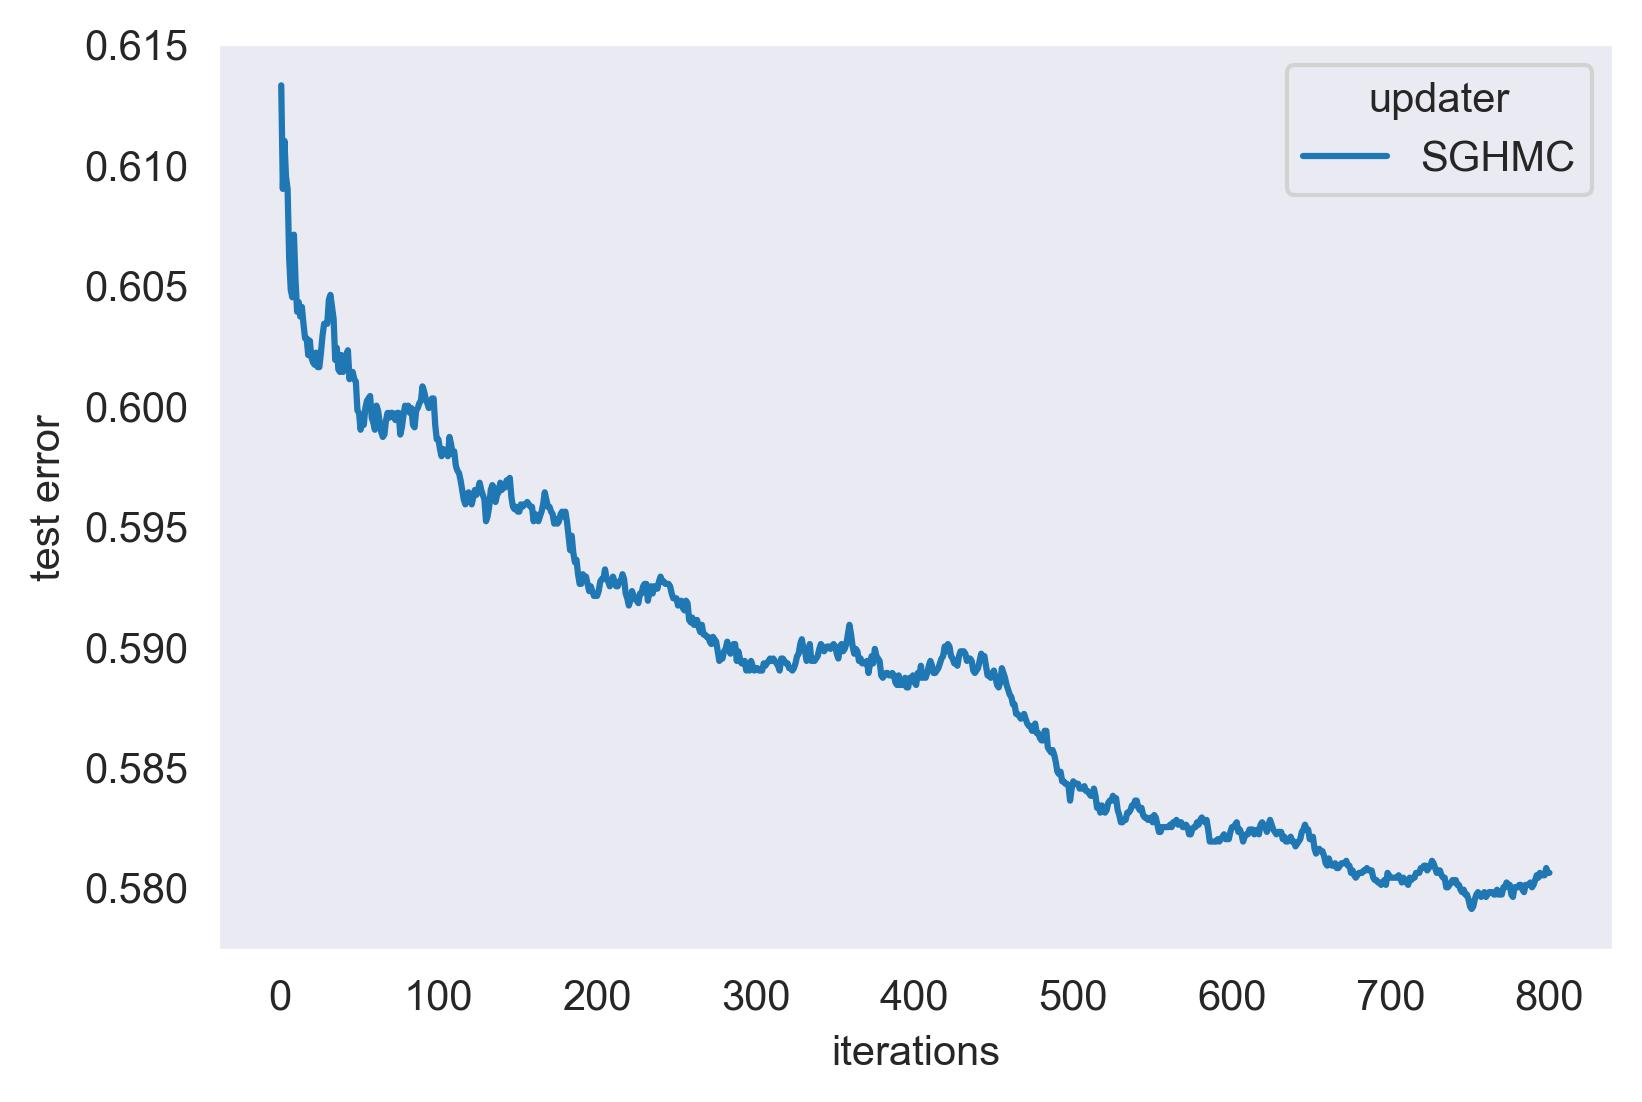

In [9]:
sns.set_style("dark")
    
sghmc_test_errs = np.array(sghmc_test_errs)

err_dict = {'SGHMC' : sghmc_test_errs}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','test error'])
sns.lineplot(data=df.pivot("iterations", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300